In [24]:
"""
Step 1: Import necessary libraries

"""
import os
import cv2
import time
import torch
import glob
import math
import warnings
import torchvision
import scipy.ndimage

import numpy as np
import pandas as pd
import os.path as osp
import seaborn as sns
import PIL.Image as Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch import nn
from math import log
from os import makedirs
from torch.utils import data
from itertools import cycle
from tqdm.notebook import tqdm
from torch.autograd import Variable
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from torchvision import transforms, models
from sklearn.metrics import auc, roc_curve
from torchvision.datasets import ImageFolder
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch_geometric.utils import dense_to_sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
                           f1_score, classification_report, confusion_matrix

from pytorch_wavelets.scatternet.layers import ScatLayer 
from pytorch_wavelets.dwt.transform1d import DWT1DForward, DWT1DInverse
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score
from ROC_CM_Curves import get_ROC_Train, get_CM_Train, get_ROC_Valid, get_CM_Valid
from ROC_CM_Curves import get_ROC_Test193, get_CM_Test193, get_ROC_Test30, get_CM_Test30

print('Finished!')

Finished!


In [2]:
"""
Step 2: Data augmentation functions

"""
def add_noise(data, noise_level=0.01):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

def scaling(data, scale_factor=1.1):
    return data * scale_factor

def flipping(data):
    return data * (-1)

def shifting(data, shift_value=0.1):
    return data + shift_value

def dropout(data, drop_probability=0.1):
    mask = np.random.binomial(1, 1 - drop_probability, data.shape)
    return data * mask

def feature_shuffle(data):
    return np.apply_along_axis(np.random.permutation, 1, data)

def gaussian_filter(data, sigma=1):
    return scipy.ndimage.gaussian_filter(data, sigma=sigma)

def random_scaling(data, low=0.9, high=1.1):
    scale_factors = np.random.uniform(low, high, data.shape)
    return data * scale_factors

def magnitude_warp(data, sigma=0.2):
    from scipy.interpolate import CubicSpline
    warp_amount = np.random.normal(loc=1.0, scale=sigma, size=data.shape)
    time_steps = np.arange(data.shape[1])
    return np.array([CubicSpline(time_steps, s)(time_steps * w) for s, w in zip(data, warp_amount)])

def noise_injection(data, noise_level=0.05):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

def minor_scaling(data, scale=0.95):
    return data * scale


augmentations = [
    add_noise,
    scaling,
    flipping,
    shifting
    # dropout,
    # feature_shuffle,
    # gaussian_filter,
    # random_scaling,
    # magnitude_warp,
    # noise_injection,
    # minor_scaling
]

In [3]:
"""
Step 3: Load the training and validation dataset from text files

"""
train_path = '/public/home/Zhp/ZhuHP/LncRNA/Github-Materials/Datasets/LncRNA-GWAS/in_train.txt'
train_df = pd.read_csv(train_path, sep='\t', engine="python")
labels = train_df.iloc[:, 0]
features = train_df.iloc[:, 1:]

features = features.apply(pd.to_numeric, errors='coerce').fillna(0)
labels_binary = labels.apply(lambda x: 1 if x == 'Functional' else 0).values
print('The length of the original feature:', len(features))
print('The length of the original label:', len(labels_binary))

#  Augment dataset
augmented_features = np.vstack([aug(features.values) for aug in augmentations])
augmented_labels = np.tile(labels_binary, len(augmentations))

# Standardize the feature values
scaler = StandardScaler()
augmented_features_scaled = scaler.fit_transform(augmented_features)
print('The length of the augment feature:', len(augmented_features_scaled))
print('The length of the augment label:', len(augmented_labels))

# Split the data into training and test sets
X_train, X_valid, y_train, y_valid = train_test_split(augmented_features_scaled, augmented_labels, test_size=0.2, random_state=42)
print('X_train:',X_train.shape)
print('X_valid:',X_valid.shape)

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create DataLoader
train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_dataset = CustomDataset(X_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=True)

# Test generated dataset 
for i, (train, labels) in enumerate(train_loader):
    print('labels: ', labels.shape)
    print('train: ', train.shape)

The length of the original feature: 5721
The length of the original label: 5721
The length of the augment feature: 22884
The length of the augment label: 22884
X_train: (18307, 4569)
X_valid: (4577, 4569)
labels:  torch.Size([256])
train:  torch.Size([256, 4569])
labels:  torch.Size([256])
train:  torch.Size([256, 4569])
labels:  torch.Size([256])
train:  torch.Size([256, 4569])
labels:  torch.Size([256])
train:  torch.Size([256, 4569])
labels:  torch.Size([256])
train:  torch.Size([256, 4569])
labels:  torch.Size([256])
train:  torch.Size([256, 4569])
labels:  torch.Size([256])
train:  torch.Size([256, 4569])
labels:  torch.Size([256])
train:  torch.Size([256, 4569])
labels:  torch.Size([256])
train:  torch.Size([256, 4569])
labels:  torch.Size([256])
train:  torch.Size([256, 4569])
labels:  torch.Size([256])
train:  torch.Size([256, 4569])
labels:  torch.Size([256])
train:  torch.Size([256, 4569])
labels:  torch.Size([256])
train:  torch.Size([256, 4569])
labels:  torch.Size([256])
t

In [4]:
"""
Step 4: Load the testing dataset from text files

"""
test_path = '/public/home/Zhp/ZhuHP/LncRNA/Github-Materials/Datasets/LncRNA-GWAS/in_test.txt'
test_df = pd.read_csv(test_path,sep='\t', engine="python")
labels = test_df.iloc[:, 0]
features = test_df.iloc[:, 1:]

features = features.apply(pd.to_numeric, errors='coerce').fillna(0)
labels_binary = labels.apply(lambda x: 1 if x == 'Functional' else 0).values
print('The lenght of the original feature:', len(features))
print('The lenght of the original label:', len(labels_binary))

# Standardize the feature values
scaler = StandardScaler()
augmented_features_scaled = scaler.fit_transform(features)
print('augmented_features_scaled: ',augmented_features_scaled.shape)

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
        
# Create DataLoader
test_dataset = CustomDataset(augmented_features_scaled, labels_binary)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Test generated dataset 
for i, (test, labels) in enumerate(test_loader):
    print('labels: ', labels.shape)
    print('test: ', test.shape)

The lenght of the original feature: 1100
The lenght of the original label: 1100
augmented_features_scaled:  (1100, 4569)
labels:  torch.Size([256])
test:  torch.Size([256, 4569])
labels:  torch.Size([256])
test:  torch.Size([256, 4569])
labels:  torch.Size([256])
test:  torch.Size([256, 4569])
labels:  torch.Size([256])
test:  torch.Size([256, 4569])
labels:  torch.Size([76])
test:  torch.Size([76, 4569])


In [30]:
"""
Step 5: The path to save the trained model and results
"""
test_path = '/public/home/Zhp/ZhuHP/LncRNA/Github-Materials/Pretained_models/LncRNA_GWAS/AWTNet.pkl'
result_path = '/public/home/Zhp/ZhuHP/LncRNA/Github-Materials/Results/LncRNA-GWAS/'

In [6]:
"""
Step 6: Adative fusion function
"""
def adaptive_fusion(fc_outputs):

    num_evidence = len(fc_outputs)
    assert num_evidence == 4, "There should be exactly four fully connected layer outputs."

    BN = fc_outputs[0].shape[0]  # Batch size
    similarity_matrix = torch.zeros((num_evidence, num_evidence))

    for i in range(num_evidence):
        for j in range(i, num_evidence):
            sim = F.cosine_similarity(fc_outputs[i], fc_outputs[j], dim=1).mean()
            similarity_matrix[i, j] = sim
            similarity_matrix[j, i] = sim

    support_degrees = similarity_matrix.sum(dim=1)

    total_support = support_degrees.sum()
    credibility = support_degrees / total_support

    most_credible_index = torch.argmax(credibility)
    decision = fc_outputs[most_credible_index]

    return decision

In [7]:
"""
Step 7: Decomposition function of 1D-DWT
"""
class dwt(nn.Module):
    def __init__(self):
        super(dwt, self).__init__()
        self.LH = DWT1DForward(J=1, wave='db1', mode='zero').cuda()
    
    def forward(self, inputs):
        L, H = self.LH(inputs.cuda())           
        return L,H 

In [8]:
"""
Step 8: Conv-wave module
"""
class CNN_Wave(nn.Module):
    def __init__(self, input_dim, num_filters, kernel_size):
        super(CNN_Wave, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=kernel_size, \
                               stride=1, padding=0).cuda()
        self.pool1 = dwt().cuda()
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=kernel_size,\
                               stride=1, padding=0).cuda()
        self.pool2 = dwt().cuda()
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=num_filters, kernel_size=kernel_size, \
                              stride=1, padding=0).cuda()
        self.pool3 = dwt().cuda()
    
    def forward(self, x):
        x = x.cuda()
        L1,H1 = self.pool1(F.relu(self.conv1(x).cuda()))
        LH1 = torch.add(L1,H1[0]).cuda()
        L2,H2 = self.pool2(F.relu(self.conv2(LH1).cuda()))
        LH2 = torch.add(L2,H2[0]).cuda()
        L3,H3 = self.pool3(F.relu(self.conv3(LH2).cuda()))
        LH3 = torch.add(L3,H3[0]).cuda()
        x_mean = LH3.mean(dim=1)
        return LH3, x_mean

In [9]:
"""
Step 9: BLSTMModel module
"""
class BLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(BLSTMModel, self).__init__()
        self.conv = nn.Conv1d(in_channels=input_dim, out_channels=hidden_dim, kernel_size=1).cuda()
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, bidirectional=True, batch_first=True).cuda()
        
    def forward(self, x):
        x = x.cuda()
        conv_x = self.conv(x).cuda()
        lstm_x, _ = self.lstm(conv_x.permute(0, 2, 1))
        lstm_x = lstm_x.permute(0, 2, 1)
        return lstm_x

In [10]:
"""
Step 10: Transformer module
"""
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term) 
        pe[:, 1::2] = torch.cos(position * div_term) 
        pe = pe.unsqueeze(0) 
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.d_k = d_model // num_heads  

        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.fc_out = nn.Linear(d_model, d_model)
    def forward(self, query, key, value, mask=None):
        BN, L, D = query.size()

        Q = self.query(query).view(BN, L, self.num_heads, self.d_k).transpose(1, 2)
        K = self.key(key).view(BN, L, self.num_heads, self.d_k).transpose(1, 2)
        V = self.value(value).view(BN, L, self.num_heads, self.d_k).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention = torch.softmax(scores, dim=-1)
        out = torch.matmul(attention, V)
        out = out.transpose(1, 2).contiguous().view(BN, L, self.d_model)
        out = self.fc_out(out)
        return out

class FeedForward(nn.Module):
    def __init__(self, d_model, hidden_dim=512):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, d_model, num_heads, hidden_dim, num_layers):
        super(TransformerEncoder, self).__init__()
        self.num_layers = num_layers
        self.gru = nn.LSTM(d_model, d_model, num_layers=2, bidirectional=True, batch_first=True).cuda()
        self.attention_layers = nn.ModuleList([
            MultiHeadAttention(d_model, num_heads) for _ in range(num_layers)
        ])
        self.ff_layers = nn.ModuleList([
            FeedForward(d_model*2, hidden_dim) for _ in range(num_layers)
        ])
        self.norm_layers = nn.ModuleList([
            nn.LayerNorm(d_model) for _ in range(num_layers)
        ])
        self.norm_layers_gru = nn.ModuleList([
            nn.LayerNorm(d_model*2) for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        for i in range(self.num_layers):
            attn_out = self.attention_layers[i](x, x, x, mask)
            x1 = self.norm_layers[i](x + attn_out)  
            g_x,_ = self.gru(x1)

            ff_out = self.ff_layers[i](g_x)
            x2 = self.norm_layers_gru[i](g_x + ff_out) 
        return x2


class Transformer(nn.Module):
    def __init__(self, input_dim, d_model, num_heads, num_layers, hidden_dim, max_len=512):
        super(Transformer, self).__init__()
        self.downsample = dwt().cuda()
        self.embedding = nn.Linear((input_dim+1)//2, d_model).cuda()  
        self.positional_encoding = PositionalEncoding(d_model, max_len).cuda()
        
        self.encoder = TransformerEncoder(d_model, num_heads, hidden_dim, num_layers).cuda()

    def forward(self, x):
        x = x.cuda()
        x1, x2 = self.downsample(x)
        
        x12 = torch.add(x1, x2[0])
        em_x = self.embedding(x12).cuda() 
        pos_x = self.positional_encoding(em_x).cuda()
  
        enc_out = self.encoder(pos_x).cuda()
        return enc_out

In [11]:
"""
Step 11: Attention Layer
"""
class AttentionLayer(nn.Module):
    def __init__(self, input_dim):
        super(AttentionLayer, self).__init__()
        self.attention_weights = nn.Parameter(torch.Tensor(input_dim, 1))
        nn.init.xavier_uniform_(self.attention_weights.data, gain=nn.init.calculate_gain('relu'))
    
    def forward(self, x):
        x = x.unsqueeze(1)
        scores = torch.matmul(x, self.attention_weights).squeeze(-1)  
        attention_weights = torch.nn.functional.softmax(scores, dim=-1)  
        weighted_sum = torch.bmm(attention_weights.unsqueeze(1), x).squeeze(1)  
        return weighted_sum

In [12]:
"""
Step 12: Calculate entropy
"""
def calculate_entropy(data):
    data_flat = data.flatten()
    _, counts = np.unique(data_flat, return_counts=True)
    probabilities = counts / len(data_flat)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

In [13]:
"""
Step 13: PCA dimensionality reduction
"""
def apply_pca(data, n_components=2):
    data_flat = data.view(-1, data.size(-1)).detach().cpu().numpy()  # 展开数据
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(data_flat)
    return reduced_data

In [14]:
"""
Step 14: KMeans function
"""
def apply_kmeans(data, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(data)
    cluster_centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    return cluster_centers, labels

In [15]:
"""
Step 15: Calculate Kmeans entropy
"""
def entropy_kmeans(data, n_components=2):
    pca_data = apply_pca(data)
    kmeans_centers, kmeans_labels = apply_kmeans(pca_data)
    entropy = calculate_entropy(torch.tensor(kmeans_labels).float())
    return entropy

In [16]:
"""
Step 16: Main model ---  AWTI-Net
"""
class AWTINet(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=2, cnn_filters=32, \
                 input_dim_trans=571, lstm_hidden_dim=16, lstm_layers=2):
        super(AWTINet, self).__init__()
    # Extract features
        self.cnn = CNN_Wave(input_dim, cnn_filters, 2).cuda()
        self.bsltm = BLSTMModel(cnn_filters,lstm_hidden_dim,2).cuda()
        self.transformer = Transformer(input_dim_trans, d_model=16, num_heads=2, \
                                       num_layers=2, hidden_dim=32, max_len=32).cuda()
        self.attention = AttentionLayer(1174).cuda()
    # Classification
        self.fc_cnn_1  = nn.Sequential(
               nn.Linear(18272, 1024),
               nn.Dropout(0.1)).cuda()
        self.fc_cnn_2  = nn.Sequential(
               nn.Linear(1024, 512),
               nn.Dropout(0.1)).cuda()
        self.fc_cnn_3  = nn.Sequential(
               nn.Linear(512, 2),
               nn.Dropout(0.1)).cuda()

        self.fc_lstm_1  = nn.Sequential(
               nn.Linear(18272, 1024),
               nn.Dropout(0.1)).cuda()
        self.fc_lstm_2  = nn.Sequential(
               nn.Linear(1024, 512),
               nn.Dropout(0.1)).cuda()
        self.fc_lstm_3  = nn.Sequential(
               nn.Linear(512, 2),
               nn.Dropout(0.1)).cuda()
        
        self.fc_trans_1  = nn.Sequential(
               nn.Linear(1024, 512),
               nn.Dropout(0.1)).cuda()
        self.fc_trans_2  = nn.Sequential(
               nn.Linear(512, 384),
               nn.Dropout(0.1)).cuda()
        self.fc_trans_3  = nn.Sequential(
               nn.Linear(384, 2),
               nn.Dropout(0.1)).cuda()
        
        self.fc_com_1  = nn.Sequential(
               nn.Linear(19296, 1024),
               nn.Dropout(0.1)).cuda()
        self.fc_com_2  = nn.Sequential(
               nn.Linear(1024, 512),
               nn.Dropout(0.1)).cuda()
        self.fc_com_3  = nn.Sequential(
               nn.Linear(512, 2),
               nn.Dropout(0.1)).cuda()
        
        self.fc_att_1  = nn.Sequential(
               nn.Linear(1174, 512),
               nn.Dropout(0.1)).cuda()
        self.fc_att_2  = nn.Sequential(
               nn.Linear(512, 384),
               nn.Dropout(0.1)).cuda()
        self.fc_att_3  = nn.Sequential(
               nn.Linear(384, 2),
               nn.Dropout(0.1)).cuda()

    def forward(self, x):
        x = x.cuda()
    # CNN
        cnn_out,cnn_mean = self.cnn(x)
        cnn_fc = cnn_out.reshape(cnn_out.shape[0],cnn_out.shape[1]*cnn_out.shape[2])
    # LSTM
        lstm = self.bsltm(cnn_out).cuda()
        lstm_fc = lstm.reshape(lstm.shape[0],lstm.shape[1]*lstm.shape[2])
    # Transformer
        trans_out = self.transformer(lstm).cuda()
        trans_fc = trans_out.reshape(trans_out.shape[0],trans_out.shape[1]*trans_out.shape[2])
    # Cat all
        cat_trans_lstm = torch.cat([lstm, trans_out],dim=2)
        com_fc = cat_trans_lstm.reshape(cat_trans_lstm.shape[0],\
                                                 cat_trans_lstm.shape[1]*cat_trans_lstm.shape[2])
    # Combined Features
        lstm_mean = lstm.mean(dim=1)
        trans_mean = trans_out.mean(dim=1)
        cat_trans_lstm_mean = torch.cat([cnn_mean, lstm_mean, trans_mean],dim=1)
        att = self.attention(cat_trans_lstm_mean).cuda()

        cnn_en = entropy_kmeans(cnn_out, n_components=2)
        lstm_en = entropy_kmeans(lstm, n_components=2)
        trans_en = entropy_kmeans(trans_out, n_components=2)
        cat_en = entropy_kmeans(cat_trans_lstm, n_components=2)
        att_en = entropy_kmeans((att.unsqueeze(1)),n_components=2)
        
   # Adaptive selection
        if cnn_en<lstm_en and cnn_en<trans_en and cnn_en<cat_en:
            out_cnn = self.fc_cnn_3(self.fc_cnn_2(self.fc_cnn_1(cnn_fc).cuda()))
            return out_cnn
        elif lstm_en<cnn_en and lstm_en<trans_en and lstm_en<cat_en:
            out_lstm = self.fc_lstm_3(self.fc_lstm_2(self.fc_lstm_1(lstm_fc).cuda()))
            return out_lstm
            
        elif trans_en<cnn_en and lstm_en<lstm_en and trans_en<cat_en:
            out_trans = self.fc_trans_3(self.fc_trans_2(self.fc_trans_1(trans_fc).cuda()))
            return out_trans
        elif cat_en<cnn_en and lstm_en<lstm_en and cat_en<trans_en:
            out_com = self.fc_com_3(self.fc_com_2(self.fc_com_1(com_fc).cuda()))
            return out_com
        else:
            if att_en<cnn_en and att_en<lstm_en and att_en<trans_en and att_en<cat_en:
                out_att = self.fc_att_3(self.fc_att_2(self.fc_att_1(att).cuda()))
                return out_att
            else:    
                out_lstm = self.fc_lstm_3(self.fc_lstm_2(self.fc_lstm_1(lstm_fc).cuda()))
                out_trans = self.fc_trans_3(self.fc_trans_2(self.fc_trans_1(trans_fc).cuda()))
                out_com = self.fc_com_3(self.fc_com_2(self.fc_com_1(com_fc).cuda()))
                out_att = self.fc_att_3(self.fc_att_2(self.fc_att_1(att).cuda()))
                fc_outputs = [out_lstm, out_trans, out_com, out_att]
                best_output = adaptive_fusion(fc_outputs)
                return best_output

In [17]:
"""
Step 17: Setting
"""

device_ids= [0,1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model =  AWTINet(input_dim=X_train.shape[1], num_classes=2).to(device)
if torch.cuda.device_count() > 1:  
    print(f"Let's use {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model,device_ids=device_ids)  
model =model.cuda()
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

Let's use 4 GPUs!


In [18]:
"""
Step 18: Training function
"""
sklearn_accuracy_t = []
sklearn_precision_t = []
sklearn_recall_t = []
sklearn_f1_t = []
sklearn_sp_t = []
sklearn_auc_t = []

def train(model, optimizer, criterion, device):
    tot_loss = 0.0
    tot_acc = 0.0
    train_preds = []
    train_trues = []

    model.train()
    for i, (train_data_batch, train_label_batch) in tqdm(enumerate(train_loader), total=len(train_loader)):
        train_data_batch = train_data_batch.to(device)
        train_data_batch_un = train_data_batch.unsqueeze(1).cuda()
        train_label_batch = train_label_batch.to(device)
        model = model.to(device)
        outputs = model(train_data_batch_un)
        loss_1 = criterion(outputs, train_label_batch.long())
        loss = loss_1 
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        tot_loss += loss.data
        train_outputs = outputs.argmax(dim=1)
        train_preds.extend(train_outputs.detach().cpu().numpy())
        train_trues.extend(train_label_batch.detach().cpu().numpy())

    sklearn_accuracy = accuracy_score(train_trues, train_preds) 
    sklearn_precision = precision_score(train_trues, train_preds, average='macro')
    sklearn_recall = recall_score(train_trues, train_preds, average='macro')
    sklearn_f1 = f1_score(train_trues, train_preds, average='macro')
    tn, fp, fn, tp = confusion_matrix(train_trues, train_preds).ravel()
    specificity = tn / (tn + fp)
    auc = roc_auc_score(train_trues, train_preds)
    
    print("[Training sklearn_metrics] loss:{:.4f} accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f} specificity:{:.4f} AUC:{:.4f}".format(tot_loss, \
            sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1, specificity, auc))
    sklearn_accuracy_t.append(sklearn_accuracy)
    sklearn_precision_t.append(sklearn_precision)
    sklearn_recall_t.append(sklearn_recall)
    sklearn_f1_t.append(sklearn_f1)
    sklearn_sp_t.append(specificity)
    sklearn_auc_t.append(auc)
    
    return sklearn_accuracy_t, sklearn_precision_t, sklearn_recall_t, sklearn_f1_t,specificity,auc

In [19]:
"""
Step 19: Validation function
"""
sklearn_accuracy_v = []
sklearn_precision_v = []
sklearn_recall_v = []
sklearn_f1_v = []
sklearn_sp_v = []
sklearn_auc_v = []

def evaluate_valid(model, criterion, device):
    test_preds = []
    test_trues = []

    bestacc = 0
    best_model = model
    model.eval()
    
    with torch.no_grad():
        for i,(test_data_batch, test_data_label) in enumerate(valid_loader):
            test_data_batch = test_data_batch.to(device)# 将double数据转换为float
            test_data_batch = test_data_batch.unsqueeze(1).cuda()
            test_data_label = test_data_label.to(device)

            model = model.to(device)
            test_outputs = model(test_data_batch)
            test_outputs = test_outputs.argmax(dim=1)
            test_preds.extend(test_outputs.detach().cpu().numpy())
            test_trues.extend(test_data_label.detach().cpu().numpy())

        sklearn_accuracy = accuracy_score(test_trues, test_preds)
        sklearn_precision = precision_score(test_trues, test_preds, average='macro')
        sklearn_recall = recall_score(test_trues, test_preds, average='macro')
        sklearn_f1 = f1_score(test_trues, test_preds, average='macro')

        tn, fp, fn, tp = confusion_matrix(test_trues, test_preds).ravel()
        specificity = tn / (tn + fp)
        auc = roc_auc_score(test_trues, test_preds)
        print("[Validation sklearn_metrics] accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f} specificity:{:.4f} AUC:{:.4f}".format(sklearn_accuracy, \
               sklearn_precision, sklearn_recall, sklearn_f1,specificity, auc))
        get_CM_Train(test_trues, test_preds, result_path)
        
        sklearn_accuracy_v.append(sklearn_accuracy)
        sklearn_precision_v.append(sklearn_precision)
        sklearn_recall_v.append(sklearn_recall)
        sklearn_f1_v.append(sklearn_f1)
        sklearn_sp_v.append(specificity)
        sklearn_auc_v.append(auc)
    
        return sklearn_accuracy_v, sklearn_precision_v, sklearn_recall_v, sklearn_f1_v,specificity,auc

In [20]:
# """
# Step 19: Training model
# """
# epoches = 300

# def main():
#     for epoch in range(1, epoches + 1):
#         best_model = model
#         min_loss = 1000
#         acc_t, pc_t, re_t, f1_t, sp_t, auc_t = train(model, opt, criterion, device)
#         acc_v, pc_v, re_v, f1_v, sp_v, auc_v = evaluate_valid(model, criterion, device)
#         print('| start of epoch {:3d} '.format(epoch))
        
#         state = {'model':model.state_dict(), 'optimizer':opt.state_dict(), 'epoch':epoch}
#         torch.save(state, checkpoints_path)

# if __name__ == "__main__":
#     main()

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       670
           1       0.98      1.00      0.99       430

    accuracy                           0.99      1100
   macro avg       0.99      0.99      0.99      1100
weighted avg       0.99      0.99      0.99      1100



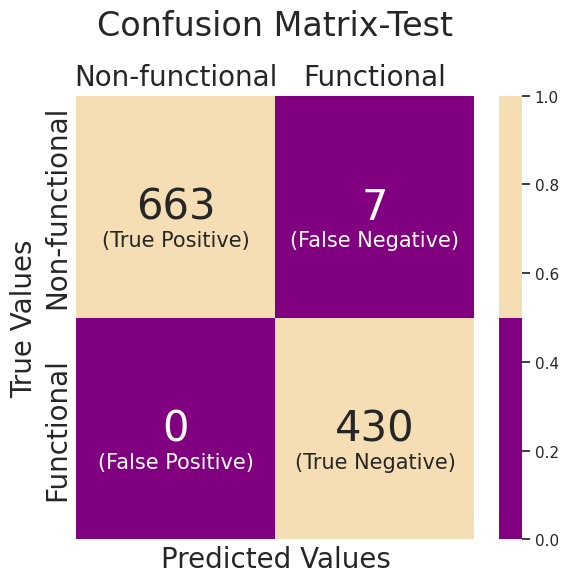

[sklearn_metrics] accuracy:0.9936 precision:0.9920 recall:0.9948 f1:0.9933 specificity:0.9896 auc:0.9948


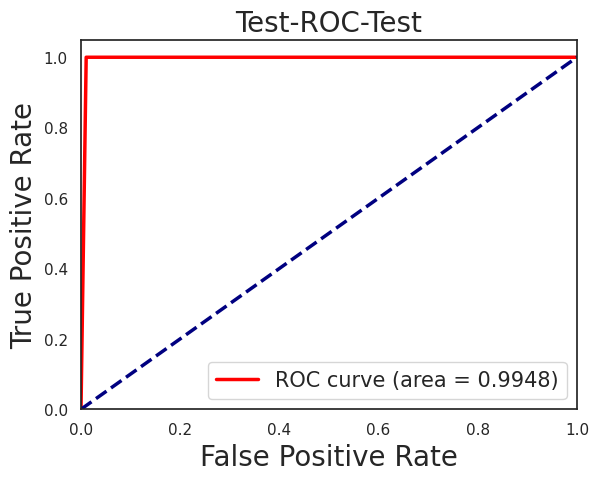

In [31]:
"""
Step 20: Evaluate test dataset
"""
def evaluate(model, criterion):
    test_preds = []
    test_trues = []
    bestacc = 0
    model.eval()
    model = AWTINet(input_dim=X_train.shape[1], num_classes=2).to(device)
    model = nn.DataParallel(model,device_ids=device_ids)
    checkpoint = torch.load(test_path)
    model.load_state_dict(checkpoint['model'])
    model.eval()
    
    with torch.no_grad():
        for i,(test_data_batch, test_data_label) in enumerate(test_loader):
            test_data_batch = test_data_batch.float().cuda()
            test_data_batch_un = test_data_batch.unsqueeze(1).cuda()
            test_data_label = test_data_label.cuda()

            model = model.cuda()
            test_outputs = model(test_data_batch_un)
            
            test_outputs = test_outputs.argmax(dim=1)
            test_preds.extend(test_outputs.detach().cpu().numpy())
            test_trues.extend(test_data_label.detach().cpu().numpy())
        sklearn_accuracy = accuracy_score(test_trues, test_preds)
        sklearn_precision = precision_score(test_trues, test_preds, average='macro')
        sklearn_recall = recall_score(test_trues, test_preds, average='macro')
        sklearn_f1 = f1_score(test_trues, test_preds, average='macro')
        cm = confusion_matrix(test_trues, test_preds)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp)
        auc = roc_auc_score(test_trues, test_preds)
        print(classification_report(test_trues, test_preds))
        get_CM_Test30(test_trues, test_preds,result_path)
        print("[sklearn_metrics] accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f} specificity:{:.4f} auc:{:.4f}".format(sklearn_accuracy, \
               sklearn_precision, sklearn_recall, sklearn_f1, specificity, auc))
        get_ROC_Test30(test_trues, test_preds, auc,result_path)
        
if __name__ == '__main__': 
    evaluate(model, criterion)
